# Malaria addInputEIR calibration

### A history matching approach to calibrating an empirical model of malaria infection and immunity

### In this version, we will be utilizing the full immune parameter space, sampling also which immune forces should be included in the calculation of the immune modifier (ie configurable params starting with "Immune_Modifier_Include*"

### For iter0 we will cut down parameter space by using the distribution of malaria prevalence by season, age and density bins from a moderate high transmission setting in Sugungum, Garki, Nigeria

# Import block

In [1]:
from IPython.extensions import autoreload
%load_ext autoreload
%autoreload 2
import os, glob, re, sys, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import itertools
from calibtool.analyzers.Helpers import \
    convert_to_counts, age_from_birth_cohort, season_from_time, aggregate_on_index

from wand.image import Image as WImage
from history_matching import HistoryMatching, HistoryMatchingCut, quick_read, Basis

import pycuda
from IPython.display import IFrame, display

from pyDOE import lhs
from history_matching import HistoryMatching, HistoryMatchingCut, quick_read, Basis
sns.set(font_scale=2)
sns.set_style("white")

c:\conda\envs\phylomodels_env\lib\site-packages\skcuda\cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


In [2]:
def fix_glob(pth):
    return re.sub('([\[\]])','[\\1]', pth)

# Configure parameters and data for history matching

In [3]:
site = 'Sugungum'
season_cut = 'W2'
age_bin_cut = 8
density_bin_cut = 500

cut_name = f'{density_bin_cut}_{age_bin_cut}_{season_cut}_{site}'

# iteration = int(re.search(r'iter(\d+)', os.getcwd())) # Index of the current iteration
iteration = 0 
#list of exp_ids/folders that correspond to exp_ids from which our emulation will draw
exp_ids = ['95069dad-6674-ea11-a2c5-c4346bcb1550'] # TODO: only uses first for now, should loop
basedir = 'C:\git\Malaria-Uganda-PRISM'
datafile = os.path.join('..','reference data', 'Garki_df.csv')

In [4]:
# The implausibility threshold determines how willing we are to retain regions
# of parameter space that are inconsistent with the underlying data. A higher
# threshold is more risk averse in that potentially good regions are less likely
# to be rejected, however it will take more iterations/simulations to achieve results.
implausibility_threshold = 3
training_fraction = 0.75 # Fraction of simulations to use as training
discrepancy_std = 0.0 # Accounts for uncertainty w.r.t model structure
n_samples_to_generate_for_next_iter = 1000 # Number of simulations to conduct on this iteration

In [5]:
# Here we define the parameter names and ranges
params_file = os.path.join('..','Params.xlsx')
param_info = quick_read(params_file, 'Params').set_index('Name')
param_names = param_info.index.tolist()

params = param_info.index.values
n_params = param_info.shape[0] # We'll use this one place later
display(param_info)

Reading Params from ..\Params_fa36f7cba078b899ab0054b93a1dd4ae.hd5


,Min,Max,MapTo
Name,,,
Biological_Age_Immune_Coefficient_PPP,0.0,10.0,Biological_Age_Immune_Coefficient_PPP
Biological_Age_Immune_Coefficient_TM,0.0,1.0,Biological_Age_Immune_Coefficient_TM
Cumulative_Exposure_Immune_Coefficient_PPP,0.0,10.0,Cumulative_Exposure_Immune_Coefficient_PPP
Cumulative_Exposure_Immune_Coefficient_TM,0.0,1.0,Cumulative_Exposure_Immune_Coefficient_TM
Recent_Exposure_Immune_Coefficient_PPP,0.0,10.0,Recent_Exposure_Immune_Coefficient_PPP
Recent_Exposure_Immune_Coefficient_TM,0.0,1.0,Recent_Exposure_Immune_Coefficient_TM
Strain_Diversity_Immune_Coefficient_PPP,0.0,10.0,Strain_Diversity_Immune_Coefficient_PPP
Strain_Diversity_Immune_Coefficient_TM,0.0,1.0,Strain_Diversity_Immune_Coefficient_TM
Malaria_Free_Interval_Immune_Coefficient_TM,0.0,1.0,Malaria_Free_Interval_Immune_Coefficient_TM


## Read in Sim Results

In [6]:
all_samples = []
all_results = []
for exp_id in exp_ids:
    
    print('-'*80, '\nExperiment:', exp_id)
    sim_results_fn = os.path.join(exp_id, 'full_analyzer_results.csv')
    print(sim_results_fn)
    sr = pd.read_csv(sim_results_fn, skipinitialspace=True)
    
    sr = sr[(sr.season == season_cut)&(sr.age_bin ==age_bin_cut)&(sr.density_bin==density_bin_cut)]
    print(sr.head())
    sr['Sample_Id'] = sr['sample'].apply(lambda x: '%s.%06d' % (exp_id, x))
    sr.rename(columns = {'sim_id': 'Sim
                         _Id','value':'Result'}, inplace=True)
    all_results.append( sr )
    #read in tags making a samples.xlsx file 
    s = pd.read_excel(os.path.join(exp_id, 'Samples.xlsx'))
    # s.drop('Sim_Id', axis=1, inplace=True)
    s['Sample_Id'] = s['Sample'].apply(lambda x: '%s.%06d' % (exp_id, x))
    all_samples.append( s )

#.rename(columns={'level_1': 'Year', 0: 'Cases'}) \
all_results = pd.concat(all_results) \
    .set_index(['Sample_Id', 'Sim_Id']) \
    [['Result']] \
    .sort_index()

samples = pd.concat(all_samples).set_index('Sample_Id').sort_index() # Bad because sample will be repeated across exp_id!
                       
samples.to_csv('Samples.csv')
all_results.to_csv('Results.csv')
results = all_results['Result']

results = all_results \
    .groupby(['Sample_Id', 'Sim_Id']) \
    .mean()

    
results.rename(columns={'Result':'Sim_Result'}, inplace=True)
print(type(results))
display(results.head())

-------------------------------------------------------------------------------- 
Experiment: 95069dad-6674-ea11-a2c5-c4346bcb1550
95069dad-6674-ea11-a2c5-c4346bcb1550\full_analyzer_results.csv
     Unnamed: 0  sample                                sim_id season  age_bin  \
51            0      14  af069dad-6674-ea11-a2c5-c4346bcb1550     W2        8   
114           0      16  b1069dad-6674-ea11-a2c5-c4346bcb1550     W2        8   
177           0       4  a2069dad-6674-ea11-a2c5-c4346bcb1550     W2        8   
240           0       6  a6069dad-6674-ea11-a2c5-c4346bcb1550     W2        8   
303           0      41  8e6195b3-6674-ea11-a2c5-c4346bcb1550     W2        8   

     density_bin     value  
51           500  0.059809  
114          500  0.165371  
177          500  0.258096  
240          500  0.088966  
303          500  0.068859  
<class 'pandas.core.frame.DataFrame'>


,,Sim_Result
Sample_Id,Sim_Id,
95069dad-6674-ea11-a2c5-c4346bcb1550.000000,9a069dad-6674-ea11-a2c5-c4346bcb1550,0.322242
95069dad-6674-ea11-a2c5-c4346bcb1550.000001,9c069dad-6674-ea11-a2c5-c4346bcb1550,0.138236
95069dad-6674-ea11-a2c5-c4346bcb1550.000002,9e069dad-6674-ea11-a2c5-c4346bcb1550,0.075931
95069dad-6674-ea11-a2c5-c4346bcb1550.000003,a0069dad-6674-ea11-a2c5-c4346bcb1550,0.227595
95069dad-6674-ea11-a2c5-c4346bcb1550.000004,a2069dad-6674-ea11-a2c5-c4346bcb1550,0.258096


In [7]:
def grouped_df(df, pfprdict, index, column_keep, column_del):
    """
    Recut dataframe to recategorize data into desired age and parasitemia bins

    Args:
        df: Dataframe to be rebinned
        pfprdict: Dictionary mapping postive counts per slide view (http://garkiproject.nd.edu/demographic-parasitological-surveys.html)
                to density of parasites/gametocytes per uL
        index: Multi index into which 'df' is rebinned
        column_keep: Column (e.g. parasitemia) to keep
        column_del: Column (e.g. gametocytemia) to delete
    """
    dftemp = df.copy()
    del dftemp[column_del]

    dftemp['PfPR Bin'] = df[column_keep]
    dftemp = aggregate_on_index(dftemp, index)

    dfGrouped = dftemp.groupby(['Season', 'Age Bin', 'PfPR Bin'])

    dftemp = dfGrouped[column_keep].count()
    dftemp = dftemp.unstack().fillna(0).stack()
    dftemp = dftemp.rename(column_keep).reset_index()
    dftemp['PfPR Bin'] = [pfprdict[p] for p in dftemp['PfPR Bin']]

    dftemp = dftemp.set_index(['Season', 'Age Bin', 'PfPR Bin'])

    return dftemp

In [8]:
ref_data_path = os.path.join('..','reference data','Garki_df.csv')
df = pd.read_csv(ref_data_path)

self = pd.DataFrame()
self.metadata =  {
        'density_bins': [0, 50, 200, 500, np.inf],  # (, 0] (0, 50] ... (50000, ]
        'density_bin_edges':['0', '50', '200', '500'],
        'age_bins': [0, 1, 4, 8, 18, 28, 43, np.inf],  # (, 5] (5, 15] (15, ],
        'age_bin_labels':['<1', '1-4', '4-8', '8-18', '18-28', '28-43', '>43'],
        'seasons': ['DC2', 'DH2', 'W2'],
        'seasons_by_month': {
            'Apr': 'DH2',
            'June/Aug': 'W2',
            'Dec/Jan': 'DC2'
        },
        'village': 'Sugungum'
    }

df = df.loc[df['Village']==self.metadata['village']]
pfprBinsDensity = self.metadata['density_bins']
uL_per_field = 0.5 / 200.0  # from Garki PDF - page 111 - 0.5 uL per 200 views
pfprBins = 1 - np.exp(-np.asarray(pfprBinsDensity) * uL_per_field)
seasons = self.metadata['seasons']
pfprdict = dict(zip(pfprBins, pfprBinsDensity))

bins = OrderedDict([
    ('Season', self.metadata['seasons']),
    ('Age Bin', self.metadata['age_bins']),
    ('PfPR Bin', pfprBins)
])
bin_tuples = list(itertools.product(*bins.values()))
index = pd.MultiIndex.from_tuples(bin_tuples, names=bins.keys())

df = df.loc[df['Seasons'].isin(seasons)]
df = df.rename(columns={'Seasons': 'Season', 'Age': 'Age Bin'})

df2 = grouped_df(df, pfprdict, index, 'Parasitemia', 'Gametocytemia')
df3 = grouped_df(df, pfprdict, index, 'Gametocytemia', 'Parasitemia')
dfJoined = df2.join(df3).fillna(0)
dfJoined = pd.concat([dfJoined['Gametocytemia'], dfJoined['Parasitemia']])
dfJoined.name = 'Counts'
dftemp = dfJoined.reset_index()
dftemp['Channel'] = 'PfPR by Gametocytemia and Age Bin'
dftemp.loc[len(dftemp) / 2:, 'Channel'] = 'PfPR by Parasitemia and Age Bin'
dftemp = dftemp.rename(columns={'Seasons': 'Season', 'PfPR Bins': 'PfPR Bin', 'Age Bins': 'Age Bin'})
dftemp = dftemp.set_index(['Channel', 'Season', 'Age Bin', 'PfPR Bin'])

# how to set the cwd
ref_data =dftemp
ref_data['bin_pop'] = ref_data.groupby(by=['Channel', 'Season', 'Age Bin'])['Counts'].sum()
ref_data['proportion'] = ref_data['Counts'] / ref_data['bin_pop']
ref_data.reset_index(inplace=True)
ref_data = ref_data[ref_data['Channel'] == 'PfPR by Parasitemia and Age Bin']

new_ref_df = pd.DataFrame()
for i, grouping in ref_data.groupby(by=['Channel', 'Season', 'Age Bin']):
    group_subset = pd.DataFrame()
    
    low = grouping[grouping['PfPR Bin'] == 50]
    low.proportion += grouping[grouping['PfPR Bin'] == 0]['proportion'].values[0]
        
    middle = grouping[grouping['PfPR Bin'] == 500]
    middle.proportion += grouping[grouping['PfPR Bin'] == 200]['proportion'].values[0]
    
    high = grouping[grouping['PfPR Bin'] == np.inf]
    new_ref_df = pd.concat([new_ref_df,low,middle,high])
new_ref_df.drop('Counts',axis = 1, inplace=True)    
new_ref_df = new_ref_df[(new_ref_df.Season == season_cut) & (new_ref_df['Age Bin'] == age_bin_cut) & (new_ref_df['PfPR Bin'] == density_bin_cut)]
new_ref_df['binomial error'] = np.sqrt((new_ref_df['proportion']*(1-new_ref_df['proportion']))/new_ref_df['bin_pop'])
print(new_ref_df)
mean = new_ref_df.proportion
error = new_ref_df['binomial error']


desired_result = mean.values[0]
desired_result_std = error.values[0]

print('Before logit, desired result is %.3f [%.3f, %.3f]: ' % (desired_result, desired_result-2*desired_result_std, desired_result+2*desired_result_std))


c:\conda\envs\phylomodels_env\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  app.launch_new_instance()
c:\conda\envs\phylomodels_env\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


                             Channel Season Age Bin  PfPR Bin  bin_pop  \
188  PfPR by Parasitemia and Age Bin     W2     8.0     500.0    162.0   

     proportion  binomial error  
188    0.487654        0.039272  
Before logit, desired result is 0.488 [0.409, 0.566]: 


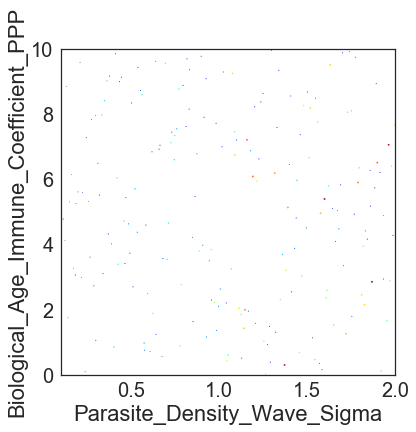

In [9]:
z = pd.merge(samples, results, on='Sample_Id') # Return to Sample_Id

#sub in variables here, can be list of tuples
xyvars = [('Parasite_Density_Wave_Sigma',	'Biological_Age_Immune_Coefficient_PPP'
)]
for (xvar, yvar) in xyvars:
    fig = plt.figure(figsize=(6,6))
    plt.scatter(z[xvar], z[yvar], c=100*z['Sim_Result'], s=5*z['Sim_Result'], cmap='jet')
    plt.xlabel(xvar); plt.ylabel(yvar)
    plt.xlim([param_info.loc[xvar, 'Min'], param_info.loc[xvar, 'Max']])
    plt.ylim([param_info.loc[yvar, 'Min'], param_info.loc[yvar, 'Max']])
    # TODO: Show as surface and plot desired result as isocline
plt.show()

In [10]:
# Finally we get to do some History Matching!
# Begin by creating an instance of the HistoryMatching class
print(type(results))
ext = 'svg' # Filetype for figures produced by history matching
hm = HistoryMatching(
    cut_name = cut_name,
    param_info = param_info,
    inputs = samples,
    results = results.squeeze(),
    desired_result = desired_result,
    desired_result_var = desired_result_std**2,
    iteration = iteration,
    implausibility_threshold = implausibility_threshold,
    discrepancy_var = discrepancy_std**2,
    training_fraction = training_fraction,
    
)
hm.save() # Save to disk

<class 'pandas.core.frame.DataFrame'>
Welcome to IDM History Matching!
Found 200 unique parameter configurations, each of which is repeated 1 time(s).
--> Training with 150 unique parameter configurations ( 150  simulations including replicates)
--> Testing  with 50  unique parameter configurations ( 50 simulations including replicates)


In [11]:
try:
    existing_basis = True
    need_basis = True
    with open(os.path.join('Cuts', cut_name, 'basis_glm.json')) as data_file:
        config = json.load( data_file )
        basis_glm = Basis.deserialize(config['Basis'])
        fitted_values = pd.read_json(config['Fitted_Values'], orient='split').set_index(['Sample_Id', 'Sim_Id']).squeeze()
except:
    existing_basis = False
    
if existing_basis:
    print('Found existing GLM basis with the following terms:')
    display(basis_glm.model_terms)
    reply = input('Would you like to use this basis? [Y]/n: ')
    
    if reply.lower() != 'n':
        need_basis = False
    
if need_basis:
    basis_glm = Basis.polynomial_basis(params=param_names, intercept = True, first_order=True, second_order=True, third_order=False, param_info=param_info)

    basis_glm.plot_regularize(samples, results, alpha = np.logspace(-5, -2, 15), scaleX=True)
    alpha_glm = float(input('What would you like to use for the GLM regularization parameter, alpha_glm = '))
#     alpha_glm = 1e-1
    
    fitted_values = basis_glm.regularize(samples, results, alpha = alpha_glm, scaleX=True)
    print('Regularization for GLM selected:\n', ' *','\n * '.join(basis_glm.get_terms()))
    with open(os.path.join('Cuts', cut_name, 'basis_glm.json'), 'w') as fout:
        json.dump( {
            'Basis': basis_glm.serialize(),
            'Fitted_Values': fitted_values.reset_index().to_json(orient='split')
        }, fout, indent=4)

Found existing GLM basis with the following terms:


[Term([]),
 Term([EvalFactor('Recent_Exposure_Immune_Coefficient_PPP')]),
 Term([EvalFactor('Scale_Factor_Rec_Exp_steepness')]),
 Term([EvalFactor('Scale_Factor_Age_b')]),
 Term([EvalFactor('Parasite_Density_Wave_Sigma')]),
 Term([EvalFactor('Biological_Age_Immune_Coefficient_PPP * Strain_Diversity_Immune_Coefficient_PPP')]),
 Term([EvalFactor('Cumulative_Exposure_Immune_Coefficient_PPP * Parasite_Density_Wave_Sigma')]),
 Term([EvalFactor('Recent_Exposure_Immune_Coefficient_PPP * Immune_Modifier_Include_Recent_Exposure')]),
 Term([EvalFactor('Scale_Factor_Strain_Diversity_n * Immune_Modifier_Include_Cumulative_Exposure')]),
 Term([EvalFactor('Prevalence_Threshold_For_Diversity * Immune_Modifier_Include_Strain_Diversity')]),
 Term([EvalFactor('Scale_Factor_Age_b * Immune_Modifier_Include_Cumulative_Exposure')]),
 Term([EvalFactor('Parasite_Density_Wave_Sigma * Immune_Modifier_Include_Cumulative_Exposure')]),
 Term([EvalFactor('Parasite_Density_Wave_Sigma * Immune_Modifier_Include_Recent

Would you like to use this basis? [Y]/n: y


In [12]:
# Now fit the glm and plot

### GLM ###############################################################
print("="*80, "\nGeneralized Linear Modeling\n", "="*80)
#######################################################################
f = hm.glm(
    basis = basis_glm,
    family = 'Poisson',
    force_optimize_glm = True,
    glm_fit_maxiter = 1000,
    plot = True, #force_optimize_glm,
    plot_data = True
)

Generalized Linear Modeling
Using Poisson family
Fitting the GLM
Fitting the model, please wait ...
                 Generalized Linear Model Regression Results                  
Dep. Variable:             Sim_Result   No. Observations:                  150
Model:                            GLM   Df Residuals:                      134
Model Family:                 Poisson   Df Model:                           15
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -53.336
Date:                Thu, 02 Apr 2020   Deviance:                       4.6677
Time:                        11:25:07   Pearson chi2:                     4.50
No. Iterations:                     4   Covariance Type:             nonrobust
                                                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

In [13]:
for file in glob.glob(fix_glob(os.path.join(hm.glmdir, "PairwiseResults", "*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

In [14]:
# Results get saved to disk, so load and display:
for file in glob.glob(fix_glob(os.path.join(hm.glmdir, "GLM Predicted vs Actual*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

In [15]:
basis_gpr = Basis.polynomial_basis(
#     params =  [
# 'Scale_Factor_Age_a', 
# 'Cumulative_Exposure_Immune_Coefficient_TM',
# 'Recent_Exposure_Immune_Coefficient_PPP',
# 'Recent_Exposure_Immune_Coefficient_TM',
# 'Parasite_Density_Wave_Sigma',
# 'Immune_Modifier_Include_Age',
# 'Immune_Modifier_Include_Strain_Diversity',
# 'Immune_Modifier_Include_Cumulative_Exposure'
#               ],
    params = param_info.index.values, 
    intercept = False, 
    first_order = True, 
    param_info=param_info)

In [16]:

### GPR ###############################################################
print("="*80, "\nGaussian Process Regression\n", "="*80)
#######################################################################
hm.gpr(
    basis = basis_gpr,
    force_optimize_gpr = True,

    sigma2_f_guess = 0.6,
    sigma2_f_bounds = (0.1, 1000),
    sigma2_n_guess =  2.0,
    sigma2_n_bounds = (0.01, 100),

    #lengthscale_guess = [7.49636161e+01 4.30910765e-02 2.18296911e+01 8.08185597e+01
#  5.86791240e-02 4.55925184e+01 7.61216580e+01 3.72424498e-01
#  9.24611775e-01 7.41104089e-01]
    lengthscale_guess = 0.25,
    lengthscale_bounds = (0.01, 100),

    optimize_sigma2_n = True,
    log_transform = False,

    verbose = True,
    optimizer_options = {
        'eps': 5e-3,
        'disp': True,
        'maxiter': 15000,
        'ftol': 2 * np.finfo(float).eps,
        'gtol': 2 * np.finfo(float).eps,
    },
    plot = True, #force_optimize_gpr,
    plot_data = False
)

Gaussian Process Regression
Autoinit GPU device name: GeForce GTX 965M
max_threads_per_block 1024
max_block_dim (1024, 1024, 64)
max_grid_dim (2147483647, 65535, 65535)
max_blocks_per_grid 2147483647
block_dim (1024, 1, 1)
grid_dim (22, 1, 1)


c:\conda\envs\phylomodels_env\lib\site-packages\history_matching\gpr.py:371: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  mod = compiler.SourceModule(kernel_code)


Fitting the GPR


c:\conda\envs\phylomodels_env\lib\site-packages\pycuda\elementwise.py:75: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  options=options, keep=keep)
c:\conda\envs\phylomodels_env\lib\site-packages\pycuda\elementwise.py:123: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  options=options, keep=keep)



	LL: 238.5560268412597 
	Theta: [0.6  2.   0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25] 
	Deriv: [ 1.79422556e+01  1.75795036e+01  1.57962698e-01 -1.59163675e-01
  4.79470868e-01  3.68935154e-01 -2.13353124e-02  4.00072893e-02
  7.00835547e-02  9.21037156e-02  1.93658676e-01  1.42347123e-01
 -4.13528109e-02 -9.73983936e-02 -1.91981112e-03 -8.51481312e-02
  3.74234275e-01  2.17431698e-01 -7.84695451e-02 -1.34744109e-03
 -6.46971324e-02 -4.90035522e-02]

	LL: 654.1003304562894 
	Theta: [0.1        0.01       0.0920373  0.40916368 0.01       0.01
 0.27133531 0.20999271 0.17991645 0.15789628 0.05634132 0.10765288
 0.29135281 0.34739839 0.25191981 0.33514813 0.01       0.0325683
 0.32846955 0.25134744 0.31469713 0.29900355] 
	Deriv: [-5.51640385e+03 -5.51664461e+03 -8.13245097e-01 -1.28668597e-01
  1.14125092e+00 -2.63971769e+01  9.34725345e-02 -1.92780359e-01
 -4.68353063e-01 -3.49213450e-01 -7.39003522e+00  1.88805379e+00
 -2.12067


	LL: 198.4411132898279 
	Theta: [1.06098227 0.0126923  1.06189501 1.58887524 0.11444637 0.11890353
 1.32597108 2.08111261 1.85744174 0.65547935 1.4879994  0.09905591
 1.67737584 1.81884473 1.40178851 1.92322748 0.05357129 0.01
 1.07215186 0.79931749 1.29567475 1.30313767] 
	Deriv: [ 9.36225046e+00  1.57333501e+01 -2.62730298e-01 -3.90905247e-01
 -1.76174007e+00 -7.38654187e+00 -6.78575383e-01 -2.47781261e-01
 -3.30050009e-01 -1.31580995e+00  2.99420159e-01 -5.55741846e+00
  1.40849457e-01 -3.91467787e-01 -3.53273267e-01 -3.97599621e-01
  3.18720202e+00 -1.57140730e-18  3.12241588e-02 -2.39077595e-01
 -7.30928693e-01  9.38633610e-01]

	LL: 197.95821584223262 
	Theta: [0.95400445 0.01       0.97568918 1.47299803 0.11363807 0.1464205
 1.22900424 1.90939047 1.70468756 0.61664593 1.35953333 0.11592269
 1.54612631 1.67896439 1.29582263 1.7730535  0.03851361 0.01
 0.99921687 0.74929485 1.20375086 1.20435165] 
	Deriv: [ 3.82231437e+00  1.04015691e+01 -3.03604338e-01 -5.41590251e-01
  1.139344

	LL: 194.26157004803076 
	Theta: [0.96625287 0.01       1.71655467 2.82315026 0.12551371 0.12401842
 2.53752117 3.5011697  3.23867925 1.85236824 1.94812278 0.1330684
 2.23020483 3.09899987 2.38525826 3.36681419 0.03695151 0.01654535
 0.84581788 1.05510691 2.08790164 0.67972443] 
	Deriv: [ 2.64871930e+00  9.78187577e+00 -9.91202067e-02 -1.82612603e-01
 -3.45084296e+00  2.60776047e+00 -1.32736814e-01 -7.44639661e-02
 -1.08959311e-01 -1.91848679e-01  5.24629776e-01 -8.14660656e-01
  2.03996813e-01 -1.14674035e-01 -1.13009924e-01 -1.75339785e-01
  1.01021970e+01 -7.20843989e-10 -1.07010369e+00  5.83633283e-01
 -4.76950980e-02 -4.29818596e-02]

	LL: 197.18373172118646 
	Theta: [0.83542009 0.01       2.05315241 3.46700593 0.13561221 0.14119214
 3.17423322 4.24304946 3.96029584 2.48777313 2.17875131 0.18333302
 2.51537889 3.76815195 2.90064816 4.12147206 0.01       0.02255872
 0.73241856 1.18735874 2.50434951 0.34816023] 
	Deriv: [-8.46672593e+00 -2.74574471e+00 -1.25075408e-01 -1.65012370e-0


	LL: 193.37010159390098 
	Theta: [1.01313577 0.01       2.72406705 4.50032873 0.14678289 0.09234452
 4.09077237 5.60405943 5.21449015 3.1367586  2.75015198 0.10999086
 3.28843902 4.92525102 3.79883384 5.40225614 0.03860754 0.02323855
 1.56906666 1.07104259 3.23492195 0.67880554] 
	Deriv: [ 1.41118740e+00  4.92022325e+00 -1.11385982e-02 -6.36008506e-02
 -5.87250732e+00 -6.02113849e+00 -5.16917208e-02 -2.92435374e-02
 -2.71418205e-02 -1.59741980e-02  4.41823549e-01  5.22177703e+00
  1.94112208e-01 -4.01457172e-02 -3.89034115e-02 -6.06539847e-02
  2.76522460e+01 -2.95868405e-06 -2.83601157e-01  1.40396971e+00
  5.06731879e-02  1.05320089e+00]

	LL: 193.05906668932386 
	Theta: [1.05182662 0.01       2.95579264 4.87796629 0.17348956 0.10151323
 4.43217198 6.08062187 5.65913383 3.40511624 2.9048875  0.11065625
 3.52694936 5.33749157 4.11954958 5.86250073 0.03742356 0.02565391
 1.84259716 0.98998026 3.48951491 0.70880904] 
	Deriv: [ 1.77296886e+00  5.34271958e+00 -3.27667572e-03 -6.08068309e

	LL: 190.49775105322357 
	Theta: [1.24392016e+00 1.00000000e-02 5.82071366e+00 9.67193233e+00
 5.27418642e-01 1.09276804e-01 8.82797486e+00 1.20306373e+01
 1.12495370e+01 7.03012488e+00 4.80224240e+00 1.25587203e-01
 6.38437011e+00 1.05196167e+01 8.14489519e+00 1.16622858e+01
 3.95077501e-02 6.05515472e-02 4.61354638e+00 2.96455193e-01
 6.68921466e+00 6.03971462e-01] 
	Deriv: [ 0.71252063 -1.53346501  0.06265715 -0.03349577 -1.16542583  1.22161485
  0.05908117 -0.02291953 -0.01555858  0.08805415  0.08260096  5.85931817
  0.01307058  0.05497784  0.02356355 -0.03063699  7.51191549 -0.09739518
 -0.2750431   0.74356632  0.02862556  0.12647138]

	LL: 190.75041947551586 
	Theta: [1.27545151e+00 1.37395330e-02 7.10806196e+00 1.17914200e+01
 7.16712082e-01 9.92142182e-02 1.07816299e+01 1.47174082e+01
 1.37642787e+01 8.60584988e+00 5.87295751e+00 6.06534657e-02
 7.77598325e+00 1.28418245e+01 9.94249575e+00 1.42464770e+01
 4.55409328e-02 7.18834169e-02 5.58707763e+00 3.38095008e-01
 8.15188107e+

	LL: 189.89100515083058 
	Theta: [ 1.07939257  0.05004343  9.20578899 15.35530396  0.96865546  0.06647184
 14.10583625 19.13853094 17.93381596 11.42695687  7.48804003  0.05180634
  9.92747329 16.69586561 12.92643516 18.55321568  0.0602555   0.09964756
  6.91111203  0.38862184 10.56617186  0.4728354 ] 
	Deriv: [-9.54130233e-01 -1.81951119e+00  1.81352262e-02 -1.87349682e-02
 -2.02825636e-01 -1.67497148e+00  2.53401672e-02 -6.39742081e-03
 -6.75051535e-03  3.89621715e-02  5.48539581e-02 -6.19206197e+00
  6.28037919e-04  2.46578107e-02  1.20417135e-02 -4.90443045e-03
 -1.48312460e+00 -6.99180384e-01 -2.34478350e-01 -1.38220090e+00
  1.06126364e-02  1.43055710e-01]

	LL: 189.87617132223534 
	Theta: [ 1.08066767  0.05356213  9.14008406 15.2347367   0.96221674  0.06933379
 13.99208376 19.00024804 17.80044321 11.31928657  7.4633477   0.05562156
  9.87743154 16.57145993 12.82980703 18.41194466  0.05909861  0.09924741
  6.86845041  0.41525014 10.49199351  0.52101755] 
	Deriv: [-1.68007601 -3.54


	LL: 189.54182499728506 
	Theta: [ 1.11848154  0.09626782 15.43974436 25.72984592  1.85816596  0.06468375
 23.69605478 32.18430303 30.17458222 19.29286863 12.46877647  0.05155799
 16.52471506 28.00526202 21.68454893 31.16098754  0.07171957  0.21786576
 11.53238357  0.5090398  17.66649801  0.54338871] 
	Deriv: [-1.80958260e+00 -1.71460216e+00  6.28216087e-03 -9.03839489e-03
  3.57019291e-01  4.21013468e-01  8.40781350e-03 -2.60027010e-03
 -3.38765771e-03  1.41060635e-02  3.00782395e-02 -2.05336994e+00
  2.92082341e-03  9.59876222e-03  5.44208607e-03 -2.19863600e-03
  2.42018422e+00  6.95134110e-01 -1.15851988e-01 -1.16051030e+00
 -1.10992152e-03  7.53568313e-01]

	LL: 189.49630680127055 
	Theta: [ 1.11771706  0.09763939 15.0781641  25.13019535  1.7968933   0.06356818
 23.14462739 31.43054373 29.46813162 18.84444248 12.19452656  0.0500925
 16.14627169 27.35181759 21.17786366 30.43202872  0.07266983  0.20687354
 11.22382045  0.54833705 17.25846535  0.52412733] 
	Deriv: [-1.29826092e+00  

	LL: 189.36783066514357 
	Theta: [ 1.28947115  0.07503475 16.72833453 27.85708303  2.0207153   0.063042
 25.65786635 34.87282484 32.69387276 20.88260161 13.54358435  0.05140821
 17.91187521 30.3301905  23.48321661 33.74988299  0.08132587  0.20408505
 12.46421236  0.65616294 19.13129243  0.56339563] 
	Deriv: [ 2.11145021e-01 -5.57206072e-01  5.79438921e-03 -9.49977267e-03
  1.61381374e-01  9.68098677e-01  7.89808574e-03 -1.97409110e-03
 -3.38530631e-03  1.47331150e-02  3.26118213e-02  1.78274054e+00
  5.33295224e-03  1.06123069e-02  5.50797535e-03 -1.67092945e-03
  3.52937957e-01  2.84177580e-01 -1.32428149e-01 -1.39546633e-01
 -2.50792859e-03 -1.08945267e-02]

	LL: 189.3652611887818 
	Theta: [ 1.30023007  0.07331865 16.98192431 28.27881351  2.05264806  0.06223139
 26.04683851 35.4029024  33.19118845 21.20064609 13.74476644  0.05129518
 18.17993238 30.78939539 23.83887497 34.26212145  0.08138005  0.19663365
 12.6584946   0.66170811 19.41956499  0.56442174] 
	Deriv: [ 3.97916162e-01 -5.1


	LL: 189.3237833356054 
	Theta: [ 1.38374265  0.08510843 22.69116796 37.78814867  2.81000961  0.06269736
 34.82732375 47.34468378 44.39866897 28.40258162 18.25581972  0.05180327
 24.19829608 41.14157248 31.85698336 45.80987463  0.09001543  0.1728903
 16.98353367  0.71912128 25.91476381  0.58170692] 
	Deriv: [ 0.33131913 -0.5743429   0.00450948 -0.0063054   0.20633809  0.1955572
  0.00406715 -0.00121672 -0.00232966  0.00953123  0.01984917 -0.36963693
  0.00541194  0.00629595  0.00359738 -0.00110096 -0.27694314  0.27720295
 -0.08560791 -0.1351399  -0.00316531 -0.09220456]

	LL: 189.32220558029604 
	Theta: [ 1.38107616  0.08535553 23.03282502 38.35827804  2.85333794  0.06229371
 35.35461243 48.06028438 45.07058049 28.83662262 18.52819393  0.0517459
 24.55880205 41.76208184 32.33746789 46.50202082  0.0902981   0.1715036
 17.23262277  0.73182679 26.30450823  0.58078422] 
	Deriv: [ 1.63992864e-01 -1.09977572e+00  4.52023126e-03 -6.14016607e-03
  2.13790273e-01  3.56616285e-01  3.95826951e-0


	LL: 189.30588704987122 
	Theta: [ 1.33368524  0.09216143 22.93238465 38.19910604  2.79688978  0.06186965
 35.20564984 47.8526798  44.87749321 28.71877099 18.42886094  0.05154663
 24.44306825 41.58234234 32.19891835 46.30481835  0.08895117  0.13475952
 17.18481479  0.70197883 26.19129605  0.56002161] 
	Deriv: [-0.01185232 -0.08806252  0.00504575 -0.00587257  0.20026316 -0.49289073
  0.00368698 -0.00121207 -0.00223661  0.00876036  0.0169681   0.05287861
  0.00590451  0.00545159  0.00312573 -0.00109654 -0.03428009 -0.21921149
 -0.07777955 -0.05770624 -0.00376563 -0.02947949]

	LL: 189.30543965712098 
	Theta: [ 1.33196351  0.09260254 22.92993683 38.19569641  2.79417917  0.0620521
 35.20239115 47.84769122 44.87296635 28.71656975 18.42491907  0.0515292
 24.43944552 41.57812938 32.1957144  46.30036286  0.08870275  0.13531203
 17.18529222  0.6982826  26.18850411  0.55739373] 
	Deriv: [ 0.01581877  0.00845046  0.0050228  -0.00585583  0.20131539  0.03113014
  0.00370388 -0.00122163 -0.00222948


	LL: 189.14099467106251 
	Theta: [1.25696895e+00 1.05890823e-01 2.51141568e+01 4.19190932e+01
 1.87077594e+00 6.57104718e-02 3.85567450e+01 5.24597573e+01
 4.92082308e+01 3.14176829e+01 1.99139889e+01 5.22457422e-02
 2.66801417e+01 4.55365964e+01 3.52743659e+01 5.07734264e+01
 7.81806856e-02 1.78129412e-01 1.96761111e+01 5.98362880e-01
 2.86972344e+01 5.62447791e-01] 
	Deriv: [ 5.76337326e-01  1.93068571e+00  2.64165226e-03 -4.18793269e-03
 -5.39186883e-03  3.25827364e+00  3.29533559e-03 -9.69585506e-04
 -1.46293428e-03  6.50470665e-03  1.40081017e-02 -2.93639470e+00
  2.37296933e-03  4.36009278e-03  2.55215898e-03 -7.44888332e-04
 -5.50964510e+00 -5.98797489e-01 -5.17515868e-02 -5.90603621e-01
 -3.15190886e-04  1.29124856e-01]

	LL: 189.1303374467597 
	Theta: [1.25602918e+00 1.06387826e-01 2.52405826e+01 4.21258197e+01
 1.94937044e+00 6.48865717e-02 3.87520576e+01 5.27222968e+01
 4.94543770e+01 3.15809618e+01 2.00251964e+01 5.21203930e-02
 2.68160966e+01 4.57663386e+01 3.54516914e+01


	LL: 189.0164992784577 
	Theta: [1.40029695e+00 9.93981969e-02 3.56751225e+01 5.95728644e+01
 2.21126680e+00 6.38927713e-02 5.47813248e+01 7.45856107e+01
 6.99761183e+01 4.46671468e+01 2.80771686e+01 5.23438486e-02
 3.77765799e+01 6.46782585e+01 5.01108728e+01 7.21736414e+01
 8.90236612e-02 2.37692957e-01 2.84145991e+01 7.30220456e-01
 4.07323324e+01 6.10638304e-01] 
	Deriv: [ 5.53797754e-01 -6.69405535e-01  1.12039493e-03 -2.60432007e-03
 -2.47985191e-03  2.67025371e+00  1.87049088e-03 -4.22919363e-04
 -8.42746654e-04  4.17378346e-03  1.03909281e-02  2.50671852e+00
  1.32527321e-03  3.08072194e-03  1.88466077e-03 -2.92231884e-04
  2.18882741e+00  9.95952370e-01 -3.34779884e-02 -4.06324338e-01
  2.47188897e-04 -1.09447922e-01]

	LL: 189.01960953746533 
	Theta: [1.39245903e+00 9.88670840e-02 3.43641578e+01 5.73781948e+01
 2.21574616e+00 6.08973619e-02 5.27686379e+01 7.18382935e+01
 6.73972374e+01 4.30262654e+01 2.70796905e+01 5.14476584e-02
 3.64039533e+01 6.23029253e+01 4.82690139e+01

	LL: 188.9520642130836 
	Theta: [1.43362698e+00 1.04115954e-01 4.45057656e+01 7.43496560e+01
 2.27377613e+00 6.27875502e-02 6.83442381e+01 9.30928707e+01
 8.73485747e+01 5.57316425e+01 3.48501704e+01 5.24096954e-02
 4.70409016e+01 8.06816240e+01 6.25176307e+01 9.00767957e+01
 9.16597926e-02 1.99403791e-01 3.59003968e+01 8.12771162e-01
 5.07980261e+01 6.58478663e-01] 
	Deriv: [ 3.96646035e-01 -2.99055933e-01  7.99066700e-04 -1.76828842e-03
 -9.47293352e-02  7.16186477e-01  1.02912940e-03 -2.29882778e-04
 -5.48612648e-04  2.75658410e-03  6.80647181e-03  1.84563564e+00
  1.32473897e-03  1.90683143e-03  1.09311789e-03 -1.78727360e-04
 -3.31293088e-01 -3.02292196e-01 -2.19482181e-02  1.42612826e-01
  7.74837837e-05  5.65492090e-01]

	LL: 188.9528034941148 
	Theta: [1.42726861e+00 1.06312040e-01 4.48267614e+01 7.48875693e+01
 2.26676946e+00 6.24984149e-02 6.88369551e+01 9.37657192e+01
 8.79802175e+01 5.61330242e+01 3.50921576e+01 5.16206971e-02
 4.73762997e+01 8.12631592e+01 6.29686653e+01 9

	LL: 188.88981317307798 
	Theta: [1.39776958e+00 1.14145113e-01 5.28283115e+01 8.82603745e+01
 2.59646487e+00 6.18348661e-02 8.11272904e+01 1.00000000e+02
 1.00000000e+02 6.61701426e+01 4.12664215e+01 5.12377858e-02
 5.57785933e+01 9.57639717e+01 7.42083486e+01 1.00000000e+02
 9.41430246e-02 1.80901364e-01 4.28139792e+01 8.28759781e-01
 6.02776590e+01 6.19131030e-01] 
	Deriv: [-9.07109481e-02  4.99387412e-01  6.85682284e-04 -1.24613735e-03
  3.22349845e-02  2.38236615e+00  6.51562243e-04 -2.29060977e-04
 -4.39079129e-04  1.87260571e-03  4.38327705e-03 -1.72878579e+00
  1.20538833e-03  1.20200873e-03  6.98385349e-04 -1.59540720e-04
  1.47643893e+00 -1.79151946e-01 -1.52711500e-02  2.89876502e-01
 -3.92027553e-04  3.46980404e-01]

	LL: 188.91273586340165 
	Theta: [1.36668642e+00 1.14792694e-01 5.58212313e+01 9.32806852e+01
 2.45130108e+00 6.11714931e-02 8.57242522e+01 1.00000000e+02
 1.00000000e+02 6.99135713e+01 4.35342992e+01 5.29438540e-02
 5.89121642e+01 1.00000000e+02 7.84151040e+01

	LL: 188.83895868140524 
	Theta: [1.29396741e+00 1.20579052e-01 6.05257360e+01 1.00000000e+02
 2.23006851e+00 6.06624276e-02 9.29476556e+01 1.00000000e+02
 1.00000000e+02 7.57946084e+01 4.70752603e+01 5.02550613e-02
 6.38284065e+01 9.70608915e+01 8.50272880e+01 1.00000000e+02
 8.76065202e-02 1.97229707e-01 4.96604850e+01 7.47991647e-01
 6.90591118e+01 5.63224191e-01] 
	Deriv: [-3.29187986e-01 -3.15535126e-01  5.63287880e-04 -8.53978537e-04
  1.89561361e-02  9.12209155e-01  5.76721740e-04 -2.16266434e-04
 -3.94758354e-04  1.31826427e-03  2.98046665e-03  8.00125498e-01
  6.42924667e-04  1.09390985e-03  5.69921512e-04 -1.27714252e-04
 -3.68835141e-01  6.05644685e-02 -1.00207797e-02 -2.97136707e-02
 -2.02123835e-05  6.56865063e-02]

	LL: 188.8376935914763 
	Theta: [1.29118232e+00 1.21000299e-01 6.07566456e+01 1.00000000e+02
 2.20969904e+00 6.02426159e-02 9.33023199e+01 1.00000000e+02
 1.00000000e+02 7.60830648e+01 4.72489338e+01 5.00030372e-02
 6.40698950e+01 9.63049480e+01 8.53519314e+01 


	LL: 188.45170050743909 
	Theta: [1.49953971e+00 9.28747883e-02 5.12153503e+01 1.00000000e+02
 2.66057190e+00 6.06889653e-02 7.86504510e+01 1.00000000e+02
 1.00000000e+02 6.41529582e+01 4.00507278e+01 5.62111671e-02
 5.40927501e+01 1.69174225e+01 7.19413567e+01 1.00000000e+02
 9.70369671e-02 1.79627654e-01 4.13795753e+01 8.24547103e-01
 5.84381900e+01 6.18638260e-01] 
	Deriv: [ 5.62830584e-02  2.11679393e+00  9.66831971e-04 -1.06668875e-03
  2.30202187e-02 -1.41863990e+01  6.00717674e-04 -2.82778303e-04
 -4.64790559e-04  1.84442979e-03  5.21868564e-03  2.87312631e+01
  1.49895456e-03  2.95148718e-02  8.55249225e-04 -2.60614528e-04
 -2.02641474e+00 -3.98978515e-01 -1.75153881e-02  4.18618769e-01
 -5.53724001e-04 -1.13149890e-01]

	LL: 188.45164215030516 
	Theta: [1.49954420e+00 9.28741879e-02 5.12151403e+01 1.00000000e+02
 2.66058175e+00 6.06889903e-02 7.86501286e+01 1.00000000e+02
 1.00000000e+02 6.41526956e+01 4.00505693e+01 5.62113007e-02
 5.40925305e+01 1.69156796e+01 7.19410616e+0


	LL: 187.73329016674515 
	Theta: [1.55839733e+00 7.95569804e-02 4.80876117e+01 1.00000000e+02
 2.84518517e+00 6.87923059e-02 7.38471767e+01 1.00000000e+02
 1.00000000e+02 6.02432476e+01 3.76936344e+01 5.06268154e-02
 5.08222004e+01 5.52607181e+00 6.75448700e+01 1.00000000e+02
 1.04319594e-01 1.82631367e-01 3.85807802e+01 8.24428702e-01
 5.48686650e+01 6.34765667e-01] 
	Deriv: [ 4.23363595e-01  1.13297092e+01  1.92502895e-04 -1.07556247e-03
  9.12850669e-02  8.14437608e+00  2.97941489e-04 -5.18132198e-04
 -3.39975403e-04  1.09987294e-03  5.89734920e-03 -9.08230401e+00
  1.81256979e-03  6.41007849e-02  7.59667505e-04 -4.37871374e-04
 -1.13557748e+00 -8.41899825e-01 -2.07660162e-02  9.48561067e-01
 -1.01416810e-03 -1.59456835e-01]

	LL: 220.02140123672467 
	Theta: [1.61509834e+00 6.55181842e-02 4.37751180e+01 1.00000000e+02
 3.11051146e+00 7.78521103e-02 6.72229263e+01 1.00000000e+02
 1.00000000e+02 5.48508300e+01 3.44291882e+01 4.87000536e-02
 4.63069518e+01 1.00000000e-02 6.14827837e+0


	LL: 187.0777191571725 
	Theta: [1.53846278e+00 1.26637684e-02 4.81458180e+01 1.00000000e+02
 2.81768334e+00 6.39995477e-02 7.39347543e+01 1.00000000e+02
 1.00000000e+02 6.03125693e+01 3.77157504e+01 4.52820103e-02
 5.08752825e+01 2.37115987e+00 6.76266981e+01 1.00000000e+02
 1.06867215e-01 1.68088813e-01 3.86849216e+01 6.91095941e-01
 5.49327771e+01 6.50653211e-01] 
	Deriv: [-1.58394519e+00 -7.80412117e-01  1.06781235e-03 -1.06170155e-03
  4.12007122e-01 -1.08143647e+00  5.21331314e-04 -5.85660299e-04
 -1.94023826e-04  1.00819668e-03  6.82942623e-03  3.90492522e+00
  1.41022285e-03 -5.19945488e-03  2.45033061e-03 -5.34412145e-04
  1.12612151e+00  4.98192752e-01 -1.71320481e-02  8.12831496e-01
  2.38004068e-03  1.84985961e+00]

	LL: 187.05268168742447 
	Theta: [1.49845775e+00 1.13974815e-02 5.04434385e+01 1.00000000e+02
 2.65937676e+00 6.26374800e-02 7.74629366e+01 1.00000000e+02
 1.00000000e+02 6.31833609e+01 3.94414276e+01 4.45895132e-02
 5.32761292e+01 2.17798036e+00 7.08565046e+01


	LL: 186.82170143150404 
	Theta: [1.38079056e+00 1.00000000e-02 6.29849125e+01 1.00000000e+02
 1.98169529e+00 5.97340917e-02 9.67224949e+01 1.00000000e+02
 1.00000000e+02 7.88627094e+01 4.88999617e+01 4.28897281e-02
 6.63911913e+01 1.91987720e+00 8.84845657e+01 1.00000000e+02
 9.70938000e-02 1.63752608e-01 5.19455711e+01 5.92364089e-01
 7.18652791e+01 4.96200770e-01] 
	Deriv: [-1.44486103e+00  1.34365322e+00  7.99544782e-04 -8.17817705e-04
  2.77099895e-01 -1.03902900e+00  4.55553405e-04 -4.93696565e-04
 -2.21170165e-04  5.50891719e-04  2.50596634e-03 -1.36010037e+00
  6.37714134e-04 -7.61613522e-03  1.25348949e-03 -3.88584116e-04
 -2.45456158e+00  6.82332955e-01 -7.87157438e-03  3.14795391e-01
  9.70437541e-04 -6.99211696e-02]

	LL: 186.8032645301626 
	Theta: [1.39885337e+00 1.00000000e-02 6.22457491e+01 1.00000000e+02
 2.01490194e+00 6.03436893e-02 9.55873345e+01 1.00000000e+02
 1.00000000e+02 7.79383649e+01 4.83412931e+01 4.30272339e-02
 6.56178726e+01 1.96580492e+00 8.74456426e+01


	LL: 186.73101381465656 
	Theta: [1.48310622e+00 1.00000000e-02 5.98747297e+01 1.00000000e+02
 2.02907025e+00 6.26355528e-02 9.19458279e+01 1.00000000e+02
 1.00000000e+02 7.49697133e+01 4.65344836e+01 4.54751139e-02
 6.31337190e+01 2.10681230e+00 8.41138116e+01 1.00000000e+02
 1.02037940e-01 9.98894909e-02 4.92418384e+01 5.84241503e-01
 6.83183845e+01 5.12327442e-01] 
	Deriv: [-2.93287228e-02  5.53033587e+00  9.42971448e-04 -9.14899033e-04
 -9.23729066e-04 -2.72777869e-02  4.44424551e-04 -5.48594069e-04
 -2.75267877e-04  6.02173365e-04  2.88033479e-03  7.38155861e-02
  9.27628499e-04  1.92152703e-03  1.50771211e-03 -4.69947144e-04
  6.20561797e-02 -2.97231804e-02 -9.94586535e-03 -2.20695644e-04
  6.31230836e-04 -2.39857418e-02]

	LL: 186.73101381465656 
	Theta: [1.48310622e+00 1.00000000e-02 5.98747297e+01 1.00000000e+02
 2.02907025e+00 6.26355528e-02 9.19458279e+01 1.00000000e+02
 1.00000000e+02 7.49697133e+01 4.65344837e+01 4.54751139e-02
 6.31337190e+01 2.10681230e+00 8.41138116e+0

GPR evaluating training data
GPR evaluating test data
max_threads_per_block 1024
max_block_dim (1024, 1024, 64)
max_grid_dim (2147483647, 65535, 65535)
max_blocks_per_grid 2147483647
block_dim (1024, 1, 1)
grid_dim (40, 1, 1)
Plotting


c:\conda\envs\phylomodels_env\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


In [17]:
pi = param_info.loc[basis_gpr.param_dict.keys()].reset_index()
pi['Lengthscale'] = hm.gpr_model.theta[2:]
print(pi[['Name', 'Lengthscale']].sort_values('Lengthscale'))

                                             Name  Lengthscale
9                 Scale_Factor_Strain_Diversity_n     0.045475
3       Cumulative_Exposure_Immune_Coefficient_TM     0.062636
15                    Immune_Modifier_Include_Age     0.099889
14                    Parasite_Density_Wave_Sigma     0.102038
19  Immune_Modifier_Include_Malaria_Free_Interval     0.512327
17        Immune_Modifier_Include_Recent_Exposure     0.584242
2      Cumulative_Exposure_Immune_Coefficient_PPP     2.029070
11             Prevalence_Threshold_For_Diversity     2.106812
8     Malaria_Free_Interval_Immune_Coefficient_TM    46.534484
16    Immune_Modifier_Include_Cumulative_Exposure    49.241838
0           Biological_Age_Immune_Coefficient_PPP    59.874730
10                 Scale_Factor_Rec_Exp_steepness    63.133719
18       Immune_Modifier_Include_Strain_Diversity    68.318385
7          Strain_Diversity_Immune_Coefficient_TM    74.969713
12                   Scale_Factor_Free_Interval_a    84

In [18]:
# Results get saved to disk, so load and display:
for file in glob.glob(fix_glob(os.path.join(hm.gprdir, "PairwiseResults", "*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

In [19]:
### Implausibility ############################################################
print("="*80, "\nImplausibility\n", "="*80)
###############################################################################
hm.calc_and_plot_implausibility(
    plot = True,
    do_plot_data = False,
    plot_data_highlight = pd.DataFrame() #hm.test_data.loc['prime.000049']
) 
    #plot_data_highlight=pd.DataFrame() # plot_data_highlight=hm.training_data.loc['prime.000049']

hm.training_data.to_excel(os.path.join('Cuts', cut_name, 'train_data.xlsx'))
hm.test_data.to_excel(os.path.join('Cuts', cut_name, 'test_data.xlsx'))

print('Good')

Implausibility
Good


In [20]:
# Results get saved to disk, so load and display:
for file in glob.glob(fix_glob(os.path.join(hm.combineddir, "*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

In [21]:
ar = all_results.reset_index()

data = ar.loc[ar['AgeBin']==age_bin[0]].groupby(['Sample_Id','AgeBin'])['Result'].mean().reset_index().set_index('Sample_Id')

train = hm.training_data
train['Train'] = True
test = hm.test_data
test['Train'] = False
train_test = pd.concat([train, test])

fig, ax = plt.subplots(figsize=(16,10))

# Reference
#ref_by_year = reference_data[['Prevalence']].reset_index()

ref_by_year = ref_df.loc[ref_df['Age bin'] == int(age_bin[0][:2])] \
    .groupby('Age bin') \
    .mean() \
    .reset_index()
print(ref_by_year)
print(data)
sns.lineplot(data=ref_by_year, x='Age bin', y='Mean', color='k', marker='o', alpha=1, lw=2, zorder=1);

# Sims
tmp = data.merge(train_test[['Sample_Orig', 'Implausible', 'Train']], left_on='Sample_Id', right_on='Sample_Orig')
print(tmp.head())
sns.lineplot(data=tmp, x='AgeBin', y='Result', hue='Implausible', style='Train', 
             units='Sample_Orig', estimator=None, alpha=0.5, lw=0.5,
             ax=ax, zorder=-1)
ax.set_xlabel('AgeBin');
ax.set_ylabel('Duration');
ax.set_xticks(ref_by_year['Age bin'].unique());

KeyError: 'AgeBin'